# Binary-Class Tabular Model for Rice Cammeo Osmancik Identification Using Python and Scikit-Learn
### David Lowe
### May 2, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Rice Cammeo Osmancik Identification dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Rice is one of the most widely produced and consumed cereal crops globally. The crop is also the main sustenance for many countries because of its economic and nutritious nature. However, before rice reaches the consumers, it must go through many manufacturing steps such as cleaning, color sorting, and classification. In this study, the research team developed a computerized vision system to classify two proprietary rice species. The dataset contains the measurements for 3,810 rice grain images. The grain image broke down into seven major morphological features for each grain of rice.

ANALYSIS: The average performance of the machine learning algorithms achieved an accuracy benchmark of 91.78% using the training dataset. Furthermore, we selected Logistic Regression as the final model as it processed the training dataset with a final accuracy score of 92.97%. When we processed the test dataset with the final model, the model achieved an accuracy score of 92.91%.

CONCLUSION: In this iteration, the Logistic Regression model appeared to be suitable for modeling this dataset.

Dataset Used: Rice Dataset Cammeo and Osmancik

Dataset ML Model: Binary classification with numerical and categorical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.18201/ijisae.2019355381

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-rice-cammeo-osmancik/Rice_Cammeo_Osmancik.arff'
colNames = ['Area','Perimeter','Major_Axis_Length','Minor_Axis_Length','Eccentricity','Convex_Area','Extent','Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=16)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent   Class  
0        15617  0.572896  Cammeo  
1        15072  0.615436  Cammeo  
2        14954  0.693259  Cammeo  
3        13368  0.640669  Cammeo  
4        15262  0.646024  Cammeo  


In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


In [9]:
print(df_dataset_import.describe())

               Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count   3810.000000  3810.000000        3810.000000        3810.000000   
mean   12667.727559   454.239180         188.776222          86.313750   
std     1732.367706    35.597081          17.448679           5.729817   
min     7551.000000   359.100006         145.264465          59.532406   
25%    11370.500000   426.144753         174.353855          82.731695   
50%    12421.500000   448.852493         185.810059          86.434647   
75%    13950.000000   483.683746         203.550438          90.143677   
max    18913.000000   548.445984         239.010498         107.542450   

       Eccentricity   Convex_Area       Extent  
count   3810.000000   3810.000000  3810.000000  
mean       0.886871  12952.496850     0.661934  
std        0.020818   1776.972042     0.077239  
min        0.777233   7723.000000     0.497413  
25%        0.872402  11626.250000     0.598862  
50%        0.889050  12706.500000     0

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Class                0
dtype: int64
Total number of NaN in the dataframe:  0


In [11]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Class').size())

Class
Cammeo      1630
Osmancik    2180
dtype: int64


### 1.d) Data Cleaning

In [12]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'Class': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent  target  
0        15617  0.572896  Cammeo  
1        15072  0.615436  Cammeo  
2        14954  0.693259  Cammeo  
3        13368  0.640669  Cammeo  
4        15262  0.646024  Cammeo  


In [13]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
 7   target             3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


In [14]:
print(df_dataset_import.describe())

               Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count   3810.000000  3810.000000        3810.000000        3810.000000   
mean   12667.727559   454.239180         188.776222          86.313750   
std     1732.367706    35.597081          17.448679           5.729817   
min     7551.000000   359.100006         145.264465          59.532406   
25%    11370.500000   426.144753         174.353855          82.731695   
50%    12421.500000   448.852493         185.810059          86.434647   
75%    13950.000000   483.683746         203.550438          90.143677   
max    18913.000000   548.445984         239.010498         107.542450   

       Eccentricity   Convex_Area       Extent  
count   3810.000000   3810.000000  3810.000000  
mean       0.886871  12952.496850     0.661934  
std        0.020818   1776.972042     0.077239  
min        0.777233   7723.000000     0.497413  
25%        0.872402  11626.250000     0.598862  
50%        0.889050  12706.500000     0

In [15]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
target               0
dtype: int64
Total number of NaN in the dataframe:  0


In [16]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
Cammeo      1630
Osmancik    2180
dtype: int64


### 1.e) Splitting Data into Sets

In [17]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (3810, 8) df_features_import.shape: (3810, 7) df_target_import.shape: (3810,)


In [18]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_target_import)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (3429, 7) df_target_train.shape: (3429,)
df_features_test.shape: (381, 7) df_target_test.shape: (381,)


### 1.f) Set up the parameters for data visualization

In [19]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [20]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [21]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

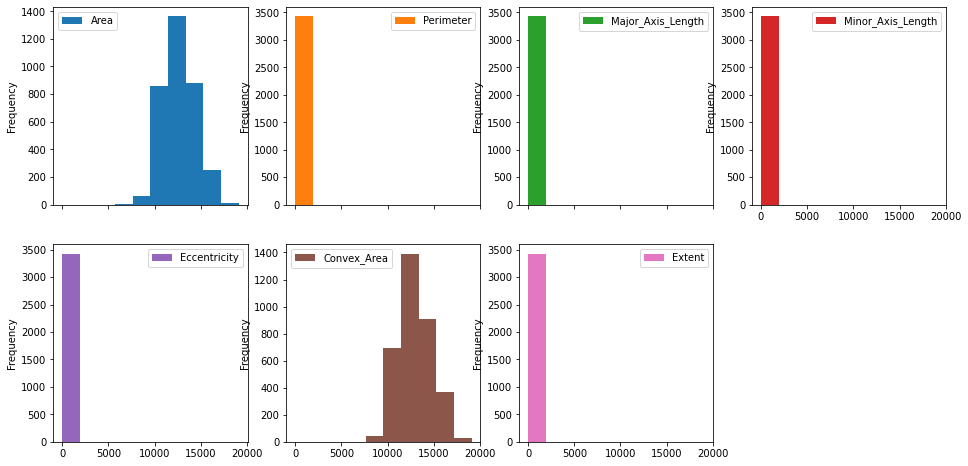

In [22]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

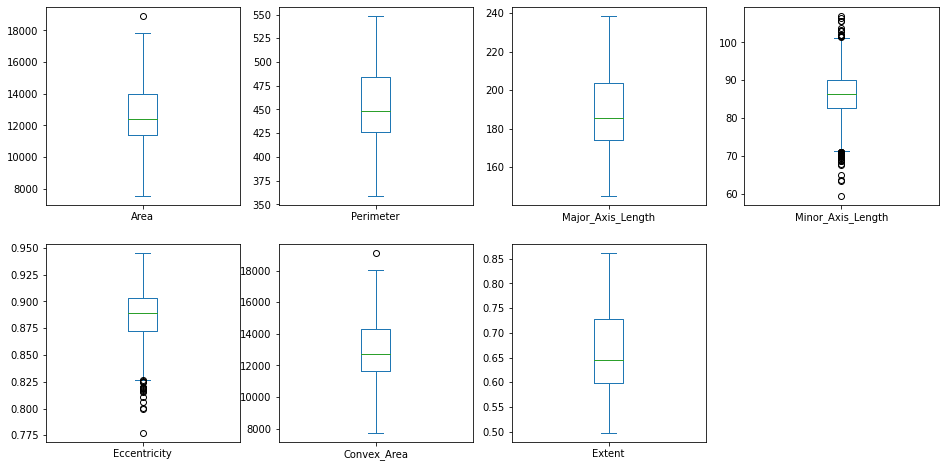

In [23]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

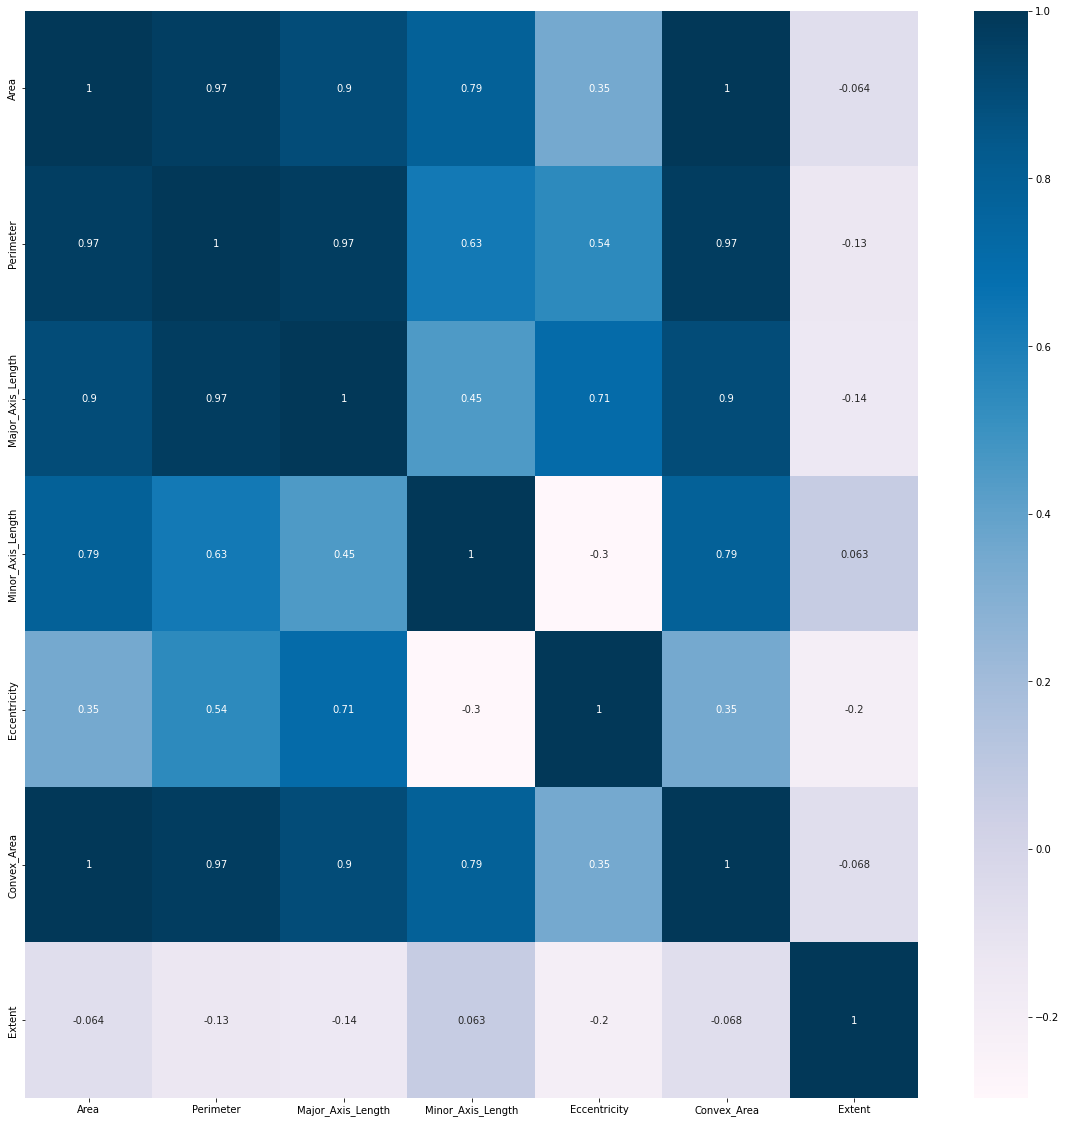

In [24]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [27]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 7
Number of categorical columns: 0
Total number of columns in the feature dataframe: 7


In [28]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (3429, 7) to array_features_train.shape: (3429, 7)


### 3.b) Training Data Balancing

In [29]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [30]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [31]:
# Finalize the training dataset for the modeling activities
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (3429, 7) array_target_train.shape: (3429,)


In [32]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [33]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [34]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [35]:
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [36]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LGR: 0.929716 (0.006998)
LogisticRegression(n_jobs=1, random_state=888)
Model training time: 0:00:00.254594 

CART: 0.891804 (0.005802)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.165634 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.922424 (0.006039)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:00.327724 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.917465 (0.007893)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:01.074675 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.924174 (0.009380)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:04.386319 

EXT: 0.921257 (0.007113)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:02.514561 

Average metrics (accuracy) from all models: 0.9178067431352103
Total training time for all models: 0:00:08.789767


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


### 4.b) Spot-checking baseline algorithms

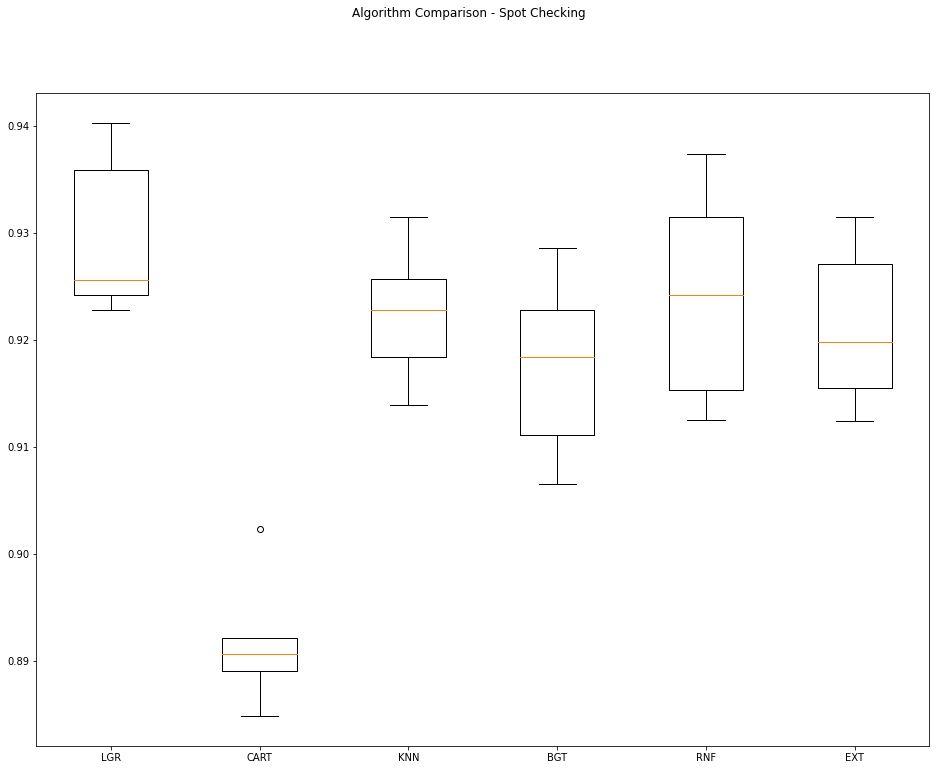

In [37]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [39]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [40]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('LGR')
paramGrid1 = dict(solver=np.array(['lbfgs','liblinear','sag','saga']))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.929716 using {'solver': 'lbfgs'}
0.929716 (0.006998) with: {'solver': 'lbfgs'}
0.928258 (0.006089) with: {'solver': 'liblinear'}
0.929716 (0.006998) with: {'solver': 'sag'}
0.929716 (0.006998) with: {'solver': 'saga'}
Model training time: 0:00:01.093760


In [41]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: solver = lbfgs


In [42]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.924174 using {'n_estimators': 100}
0.924174 (0.009380) with: {'n_estimators': 100}
0.922424 (0.009792) with: {'n_estimators': 300}
0.921258 (0.010160) with: {'n_estimators': 500}
Model training time: 0:00:30.527819


In [43]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 4.d) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


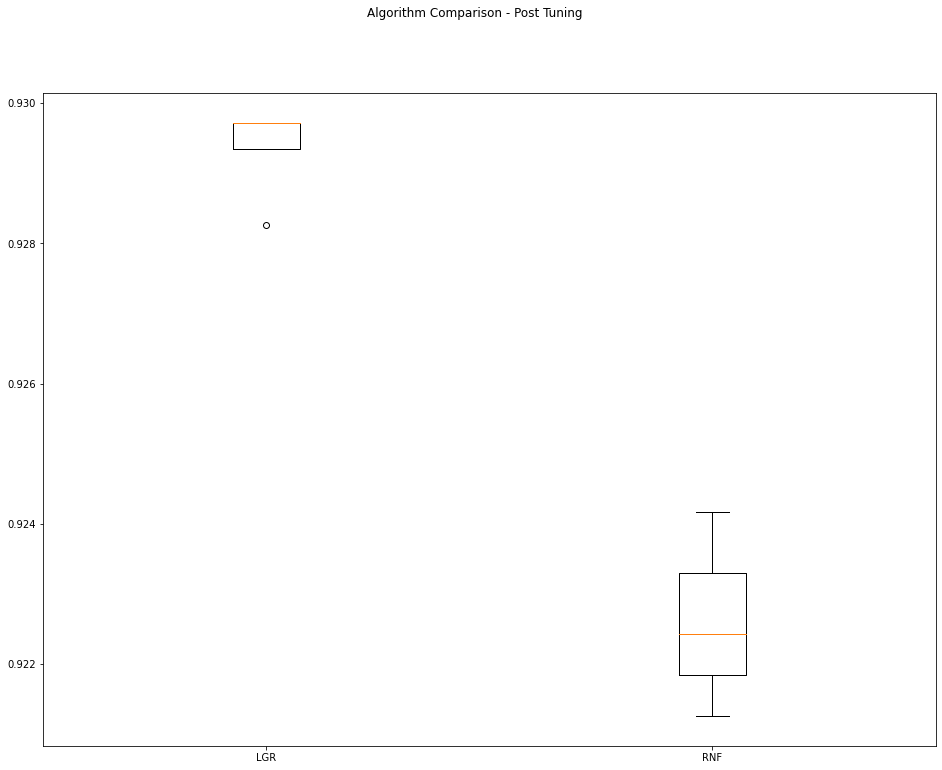

In [44]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [47]:
final_model = LogisticRegression(solver=best_paramValue1, random_state=RNG_SEED, n_jobs=N_JOBS)
# final_model = RandomForestClassifier(n_estimators=best_paramValue2, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

LogisticRegression(n_jobs=1, random_state=888)


### 5.b) Load Test Dataset and Make Predictions

In [48]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = label_encoder.transform(df_target_test)
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (381, 7) array_target_test.shape: (381,)


In [49]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1
 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0
 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0
 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1
 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0
 0 1 0 1 1 1 1 1 1 0 0]


In [50]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9291338582677166
ROC/AUC Score: 0.928786514324309
[[151  12]
 [ 15 203]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       163
           1       0.94      0.93      0.94       218

    accuracy                           0.93       381
   macro avg       0.93      0.93      0.93       381
weighted avg       0.93      0.93      0.93       381



In [51]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:00:47.027312
